In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123

/home/amoor/NuMI/NuMI_Analysis/PELEE


In [3]:
main_path = ls.main_path
sys.path.append(main_path)

In [4]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights() # the default option is FHC, RHC needs different arguments

In [5]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 10272021


In [6]:
SHRCALIBFACTOR = 1.00

In [7]:
# USING BDT?
USEBDT = True

In [8]:
# Doing Run3?
ISRUN3 = False

In [9]:
# scale to MCC8 CV?
MCC8WEIGHTS = False

In [10]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [11]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)



In [12]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265


angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [13]:
tree = "NeutrinoSelectionFilter"


#new
BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune
#This is with the new GENIE tune
DRT  = '/prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'  +ls.APPEND
"""
BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
"""
mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]


uproot_v = [mc,ext,data,dirt] 


variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nproton",
        #"nu_e", 
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        #"trk_sce_start_x_v","trk_sce_start_y_v","trk_sce_start_z_v",
        #"trk_sce_end_x_v","trk_sce_end_y_v","trk_sce_end_z_v",
        #"trk_start_x_v","trk_start_z_v","trk_start_z_v",
        "topological_score",
        "isVtxInFiducial",
        "theta", # angle between incoming and outgoing leptons in radians
    ]

varMC = ["nu_e","true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "true_nu_vtx_z", "true_nu_vtx_y", "true_nu_vtx_x"]

#make the list unique
variables = list(set(variables))
print(variables)


    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]


['backtracked_pdg', 'npion', 'CosmicIPAll3D', 'reco_nu_vtx_y', 'reco_nu_vtx_z', 'slnunhits', 'run', 'sub', 'trk_llr_pid_score_v', 'slnhits', '_opfilter_pe_veto', 'npi0', 'interaction', 'reco_nu_vtx_x', 'reco_nu_vtx_sce_z', 'pi0_e', 'isVtxInFiducial', 'evt', 'CosmicIP', 'pi0truth_elec_etot', '_opfilter_pe_beam', 'evnunhits', 'slpdg', 'category', 'nslice', 'reco_nu_vtx_sce_y', 'slclustfrac', 'CosmicDirAll3D', 'nu_pdg', 'muon_e', 'ccnc', 'nproton', 'mc_pdg', 'topological_score', 'reco_nu_vtx_sce_x', 'theta', 'true_e_visible', 'flash_pe', 'pion_e']


In [14]:
import pandas as pandas    
#dirt = dirt.pandas.df(variables + varMC + WEIGHTS + SYSTEMATICS, flatten=False)
#mc   =   mc.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
#data = data.pandas.df(variables, flatten=False)
#ext  =  ext.pandas.df(variables, flatten=False)

dirt_var = variables + varMC + WEIGHTS + SYSTEMATICS
mc_var   = variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC
data_var = variables
ext_var  = variables


# This needs modifications (add variables from above)
uproot_v = [mc,ext,data,dirt] 
var_v    = [mc_var,ext_var,data_var,dirt_var] 

for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        mc = CVDF
    elif ii == 1:
        ext = CVDF
    elif ii == 2:
        data = CVDF
    else:
        dirt =  CVDF

/home/amoor/miniconda3/envs/python3NuMIWS/lib/python3.7/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Weights

In [15]:
df_v = [mc,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [16]:
df_v = [mc,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    '''
    # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    '''


In [17]:
df_v = [mc,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']


In [18]:
df_v = [mc]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
    
    # Cray cray weight fix
    #for ievt in range(df.shape[0]):
    #    reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
    #                         (df['weightsGenie'].iloc[ievt] == np.inf))
    #    df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

In [19]:
df_v = [mc,dirt,data,ext]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

# Adding variables

In [20]:
df_v = [mc,dirt,data,ext]
for i,df in enumerate(df_v):
    df['muon_Angle_Numi_Theta']   = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['muon_theta'],x['muon_phi']) , axis=1)
    df['cosMu_Angle_Numi_target'] = np.cos(df['muon_Angle_Numi_Theta'])
    df['Q2reco']  = 2 * df['neutrino_energy'] * ( df['muon_energy'] - df['muon_momentum'] *df['cosMu_Angle_Numi_target'] ) - 0.105**2
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

data["bnbdata"] = np.ones_like(data["isVtxInFiducial"])
ext["extdata"] = np.ones_like(ext["isVtxInFiducial"])

In [21]:
def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)
    '''    
    print(len(listPx), df.shape)
    df['shr_p']       = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    ##########################################
    df['dir_mu_px']  = df['shr_px']/df['shr_p']
    df['dir_mu_py']  = df['shr_py']/df['shr_p']
    df['dir_mu_pz']  = df['shr_pz']/df['shr_p']
    
    df['nu_reco_px']  = listPx
    df['nu_reco_py']  = listPy
    df['nu_reco_pz']  = listPz
    df['BNBP']     = np.sqrt(df['nu_reco_px']*df['nu_reco_px'] + df['nu_reco_py']*df['nu_reco_py'] + df['nu_reco_pz']*df['nu_reco_pz'])
    df['BNBPt']    = np.sqrt(df['nu_reco_px']*df['nu_reco_px'] + df['nu_reco_py']*df['nu_reco_py'])
    df['BNBTheta'] = np.arccos(df['nu_reco_pz']/df['BNBP'] )
    df['BNBPhi']   = np.arctan2(df['nu_reco_py'],df['nu_reco_px'])
    df['nu_Angle_Numi_Theta'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['BNBTheta'],x['BNBPhi']) , axis=1)
    df['cosNu_Angle_Numi_Theta'] = np.cos(df['nu_Angle_Numi_Theta'])
    df['NuMIPt'] = df['BNBP'] * (np.sin(df['nu_Angle_Numi_Theta']))
    df['checkPt']  = df['BNBPt'] - df['pt']
    '''   

/home/amoor/miniconda3/envs/python3NuMIWS/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in multiply
  


# Event Categories

In [22]:
data["is_signal"] = data["category"] == 11
mc["is_signal"]   = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"]  = ext["category"] == 11

# Selection

In [22]:
# numu selection                                                                                                                                                                                                              
#NUMUPRESEL = 'nslice == 1'
#NUMUPRESEL += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
#NUMUPRESEL += ' and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251. '
#NUMUPRESEL += ' and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110. '
#NUMUPRESEL += ' and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986. '

#NUMUPRESEL2 = NUMUPRESEL + ' and topological_score > 0.06 '

#NUMUSEL = NUMUPRESEL2 + ' and n_muons_tot > 0'


# Plotting part

In [23]:
import plotter
import importlib
importlib.reload(plotter)

<module 'plotter' from '/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py'>

In [24]:
# muon selection
#QUERY = NUMUPRESEL #NUMUSEL #'nslice == 1'


In [24]:
import plotter
import importlib
importlib.reload(plotter)

#nue = mc.query("(abs(nu_pdg) == 12 and ccnc == 0)") 
#nueMC = mc.query("(abs(nu_pdg) == 14 & ccnc == 0)")
##CHANGE
nue   = mc.query("(abs(nu_pdg) == 12 & ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55)")



samples = {
    "mc"  : mc,
    "nue" : nue,
    "data": data,
    "dirt": dirt,
    "ext" : ext
}

scaling   = 1
pot       =  2e+20             
mcratio   = pot/2.33652e+21
nueratio  = pot/2.37838e+22    
dirtratio = pot/1.42143e+21
extratio  = 5268051.0/9199232.74

SPLIT = 1.0
scaling = 1
scalingEXT = 0.98
scalingDRT = 0.60 #0.35

weights = { "mc"  : mcratio  * SPLIT * scaling,
            "nue"  : mcratio  * SPLIT * scaling, #needed as the plotter needs nue but we're not using
            #"nue" : nueratio  * SPLIT * scaling,
            "ext" : extratio * SPLIT * scalingEXT,    
            "dirt": dirtratio* SPLIT * scalingDRT,   
}

my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)

{'mc': 0.08559738414394057, 'nue': 0.08559738414394057, 'ext': 0.5612087579382191, 'dirt': 0.08442202570650682}


In [26]:
# from Katerina  - modified, to be able to plot truth mc with nue eff selections
# plot efficiency overlaid on selected signal events 
def plot_signal_and_eff(selected, df, signal, bins, truth): 
    
    # generated true signal events per bin 
    gen = plt.hist(df.query(signal)['nu_e'], bins, color='deepskyblue')
    plt.close()
    
    # plot selected signal events 
    fig, ax1 = plt.subplots(figsize=(4, 5))
    
    sel = ax1.hist(truth['nu_e'], bins, color='deepskyblue')
    ax1.set_ylabel('selected signal events', fontsize=15)
    ax1.set_xlabel('true numu energy [GeV]', fontsize=15)

    # compute efficiency
    #sel2=selected['nu_e']
    sel = ax1.hist(selected['nu_e'], bins, color='white')
    eff = [ a/b for a, b in zip(sel[0], gen[0]) ]
    eff_err = []
    for i in range(len(eff)):
        eff_err.append(math.sqrt( (eff[i]*(1-eff[i]))/gen[0][i] ) )
        print("In bin", i, ", eff = ", eff[i], " with error = ", eff_err[i])
        
    # compute bin centers 
    bc = 0.5*(sel[1][1:]+sel[1][:-1])
    x_err = []
    for i in range(len(sel[1])-1): 
        x_err.append((sel[1][i+1]-sel[1][i])/2)

    # plot efficiency
    sel = ax1.hist(truth['nu_e'], bins, color='deepskyblue')
    ax1.set_ylim(0, 20000)
    ax2 = ax1.twinx()
    ax2.errorbar(bc, eff, xerr=x_err, yerr=eff_err, fmt='o', color='orangered', ecolor='orangered', markersize=3) 
    ax2.set_ylim(0, 1.00)
    ax2.set_ylabel('Efficiency', fontsize=15)
    ax2.set_title("True Numu Energy and Efficiency")
    plt.text(2, 0.65, r'MicroBooNE Preliminary')

    plt.show()

true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and (abs(nu_pdg) == 14 and ccnc == 0)& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  13.502999942997768  c  31
order w sum  87.70821125332343  c  3
order w sum  1898.8821125728982  c  5
order w sum  2228.9725775338907  c  21
order w sum  5222.460125060285  c  0
order w sum  12954.06162930338  c  2
[1.121685   4.3569602  3.29049793 2.85825717 1.11911881 0.16068989
 0.26579605 0.08950105 0.17601616 0.06447768]
sum:  13.50299994299777
[6.84744353e+01 1.68453352e+01 7.45753688e+00 5.61224130e+00
 1.96250557e+00 2.09148543e-01 2.65796053e-01 1.43718510e-01
 1.76016160e-01 6.44776788e-02]
sum:  101.21121119632122
[275.31880082 423.20021222 449.32946447 358.66659782 198.59944709
  99.84864382  74.94992326  55.64249688  38.17766011  26.36007726]
sum:  2000.093323769212
[279.74923513 601.48532911 878.3665625

/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:459: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )


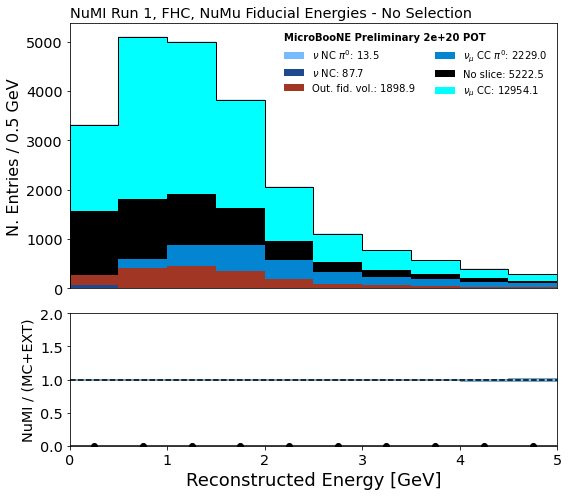

In [27]:
import matplotlib.pyplot as plt
import matplotlib

systematicsBool = False

#why is this not just nu_e?
VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

#in the fiducial volume
fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and (abs(nu_pdg) == 14 and ccnc == 0)"
FID_QUERY = fiduc

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= FID_QUERY,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = False,           #False as plotting MC
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]


ax1.set_title('NuMI Run 1, FHC, NuMu Fiducial Energies - No Selection',loc='left')
#ax2.set_ylim(0.95,1.05)

fig.tight_layout()

nslice >= 0
nslice >= 0& nslice <= 2 & nslice >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  1184.6528973373554  c  31
order w sum  2347.1468964318847  c  3
order w sum  2417.7970251854567  c  21
order w sum  13215.808157724492  c  2
order w sum  23576.997310890878  c  5
order w sum  79463.55492388699  c  0
order w sum  243.94473084531342  c  1
order w sum  0  c  12
order w sum  120.5903182191437  c  10
order w sum  390.0633804915802  c  11
[   0.    1184.653]
sum:  1184.6528973373538


IndexError: index 2 is out of bounds for axis 0 with size 2

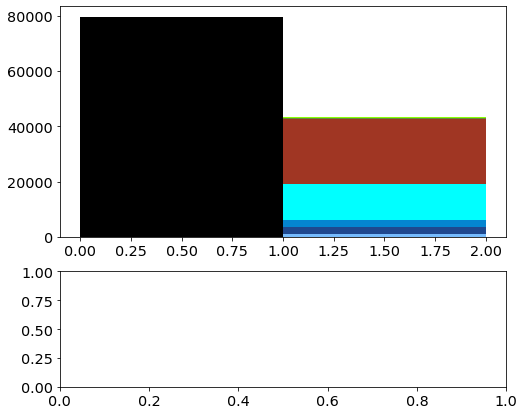

In [28]:
import matplotlib.pyplot as plt
import matplotlib

#SEL_QUERY = 'nslice == 1'
SEL_QUERY = 'nslice >= 0'
print(SEL_QUERY)
VARIABLE, BINS, RANGE, XTIT = 'nslice',2,(0.0,2.0),"SliceID"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = False,           #False as plotting MC
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, NuMu - SliceID',loc='left')
ax1.set_yscale("log")
fig.tight_layout()

#610496

145862 signal events were selected
184715  events were generated
efficiency =  0.7896597460953361
purity =  0.3240109061732062
In bin 0 , eff =  0.6785301230154558  with error =  0.003386309271676874
In bin 1 , eff =  0.7732045152067827  with error =  0.0020789329389622442
In bin 2 , eff =  0.797743755036261  with error =  0.0019554977800862227
In bin 3 , eff =  0.8110812075824947  with error =  0.002117182570652367
In bin 4 , eff =  0.8202782646801051  with error =  0.0028416991024883455
In bin 5 , eff =  0.82654904878308  with error =  0.0039034707004517565
In bin 6 , eff =  0.8248498261144483  with error =  0.004778902127510775
In bin 7 , eff =  0.8283533260632497  with error =  0.00556872582947292
In bin 8 , eff =  0.8183835182250396  with error =  0.00686366983851829


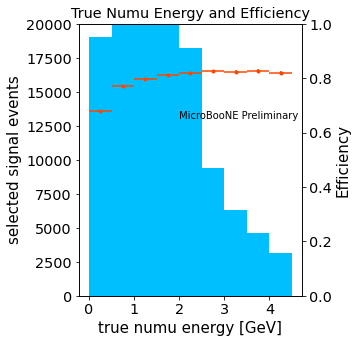

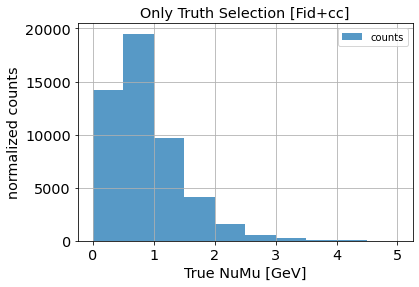

In [29]:
import matplotlib.pyplot as plt
import matplotlib
###########################################
#check the efficiency

#store efficiencies after each selection
effs = []
purs = []

effs.append(1.0)

purs.append(0.0)

#(nue.query(fiduc_q)).info()

SEL_QUERY = 'nslice == 1'
#SEL_QUERY = 'nslice == 1 and n_showers > 0 and reco_nu_vtx_sce_x > 8.45 and reco_nu_vtx_sce_x < 244.8 and reco_nu_vtx_sce_y > -106.5 and reco_nu_vtx_sce_y < 106.5 and reco_nu_vtx_sce_z > 5 and reco_nu_vtx_sce_z < 1031.8 and contained_fraction > 0.85 and (topological_score > 0.2 or topological_score < 0.01) and CosmicIPAll3D > 15 and shr_score < 0.15 and hits_ratio > 0.5 and shrmoliereavg < 7 and ((n_tracks > 0 and (((shr_tkfit_dedx_max > 0 and shr_tkfit_dedx_max < 1.75) and shr_distance <= 3)  or ((shr_tkfit_dedx_max >= 1.75 and shr_tkfit_dedx_max < 2.5) and shr_distance <= 12)  or ((shr_tkfit_dedx_max >= 2.5 and shr_tkfit_dedx_max < 3.5) and shr_distance <= 3) or ((shr_tkfit_dedx_max >= 3.5 and shr_tkfit_dedx_max < 4.7) and shr_distance <= 0) or ((shr_tkfit_dedx_max >= 4.7) and shr_distance <= 3))) or (n_tracks == 0 and ((shr_tkfit_dedx_max >= 1.7 and shr_tkfit_dedx_max < 2.7) or (shr_tkfit_dedx_max >= 5.5))))'

#selected = fullnue.query(SEL_QUERY)
selected = mc.query(SEL_QUERY)

fiduc_q = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and (abs(nu_pdg) == 14 and ccnc == 0) and nproton > 0"

#sel_fid = SEL_QUERY + ' and ' + fiduc_q
selected_fid = selected.query(fiduc_q)

#numuonly = "abs(nu_pdg) == 14"
#numucconly = "(abs(nu_pdg) == 14 and ccnc == 0)"

print(str(len(selected.query(fiduc_q)))+' signal events were selected')
print(str(len(mc.query(fiduc_q)))+'  events were generated')
selCC = len(selected.query(fiduc_q))
totCC = len(mc.query(fiduc_q))
eff = selCC/totCC                      #Selection eff = number of selected neutrino interactions
                                        #classified as either ν mu / ̄ν mu CC
                                        #divided by the total number 
                                        #of true simulated ν mu and ν mu CC interactions
                                        #in the fiducial volume
print("efficiency = ",eff)
effs.append(eff)

lnue = len(mc.query(SEL_QUERY))* 0.08559738414394057
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057    #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.08442202570650682   #check this one!!
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)

print("purity = ", pur)              #Selection purity = number of selected neutrino interactions
                                    # classified as ν mu / ̄ν mu CC
                                    # divided by the total
                                    #number of selected events regardless their 
                                    #classification (but excluding the beam-on data)
purs.append(pur)


bins = np.arange(0, 5.0, 0.5)
plot_signal_and_eff(selected_fid, mc, fiduc_q, bins, mc.query(fiduc_q))

####################################
#in the fiducial volume
fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55"

#just look for muon neutrinos
q2 = "(abs(nu_pdg) == 14 and ccnc == 0) and +" + fiduc
#in the mc data
nueMCSel  = mc.query(q2)

fig, ax = plt.subplots(nrows=1, sharex=True)

#n1, bins1, patches1 = ax[0].hist('elec_e',25,weights='weightSplineTimesTuneTimesPPFX',  range=(0,5), alpha=0.75, label='Elec')
n2, bins2, patches2 = ax.hist(nueMCSel['neutrino_energy'],10,weights=nueMCSel['weightSplineTimesTuneTimesPPFX'],  range=(0,5), alpha=0.75, label='counts')

ax.set_xlabel('True NuMu [GeV]')
ax.set_ylabel('normalized counts')
ax.set_title('Only Truth Selection [Fid+cc]')
ax.legend()
ax.grid(True)

nslice == 1
nslice == 1 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  1184.6528973373554  c  31
order w sum  2347.1468964318847  c  3
order w sum  2417.7970251854567  c  21
order w sum  13215.808157724492  c  2
order w sum  23576.997310890878  c  5
order w sum  243.94473084531342  c  1
order w sum  0  c  12
order w sum  120.5903182191437  c  10
order w sum  390.0633804915802  c  11
[0.    0.    0.    0.    0.    0.    0.    0.    1.317 0.    0.    0.
 0.    0.    0.    0.    0.    4.807 2.942 2.639 2.768 1.467 1.618 2.122
 3.009 1.078 1.907 2.24  2.285 1.483]
sum:  31.683407257708225
[ 0.     0.     0.     0.     0.     0.     0.     0.    20.473  0.
  0.     0.     0.     0.     0.     0.     0.    17.443 13.842 13.668
 13.705 10.713 11.623 13.858 11.292 11.631 10.036 10.754 11.483 10.767]
sum:  181.28645188214008
[ 0.     0.     0.     0.     0.     0.     0.     0.    21.26   0.
  0.     0.     0.     0.     0.     0.     0.    23.581 18.575 19.181
 18.439 14.075 13

/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:459: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:2281: RuntimeWarning: divide by zero encountered in true_divide
  ax.errorbar(bincenters, n_data / n_tot,


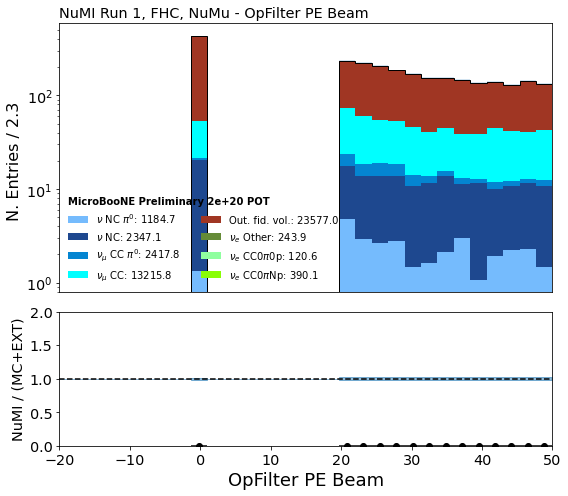

In [30]:
#_opfilter_pe_beam

import matplotlib.pyplot as plt
import matplotlib

#SEL_QUERY = 'nslice >= 0'
print(SEL_QUERY)
VARIABLE, BINS, RANGE, XTIT = '_opfilter_pe_beam',30,(-20.0,50.0),"OpFilter PE Beam"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = False,           #False as plotting MC
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, NuMu - OpFilter PE Beam',loc='left')
ax1.set_yscale("log")
fig.tight_layout()

nslice == 1
nslice == 1 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  1184.6528973373554  c  31
order w sum  2347.1468964318847  c  3
order w sum  2417.7970251854567  c  21
order w sum  13215.808157724492  c  2
order w sum  23576.997310890878  c  5
order w sum  243.94473084531342  c  1
order w sum  0  c  12
order w sum  120.5903182191437  c  10
order w sum  390.0633804915802  c  11
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 1.160e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 2.336e+00 2.722e+00 1.900e+00 9.875e-01
 1.051e+00 1.442e+00 3.668e-01 2.317e-01 5.109e-01 4.566e-01 1.847e-01
 1.501e-01 2.792e-01]
sum:  1172.8756628411252
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 3.462e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 7.136e+00 6.394e+00 4.248e+00 3.109e+00
 3.527e+00 3.646e+00 1.224e+00 1.612e+00 1.127e+00 1.0

/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:459: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:2281: RuntimeWarning: divide by zero encountered in true_divide
  ax.errorbar(bincenters, n_data / n_tot,


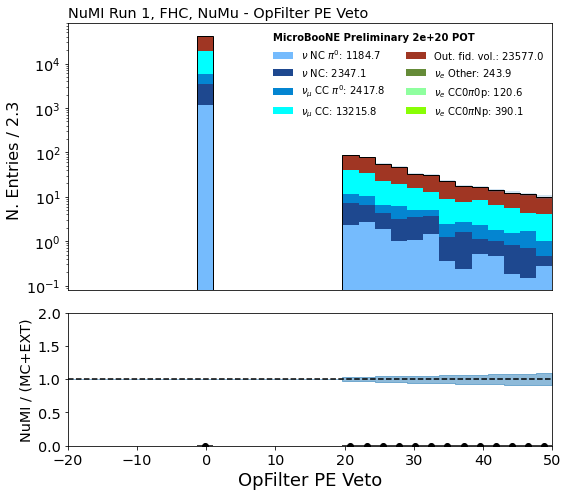

In [31]:
#_opfilter_pe_veto

import matplotlib.pyplot as plt
import matplotlib

#SEL_QUERY = 'nslice >= 0'
print(SEL_QUERY)
VARIABLE, BINS, RANGE, XTIT = '_opfilter_pe_veto',30,(-20.0,50.0),"OpFilter PE Veto"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = False,           #False as plotting MC
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, NuMu - OpFilter PE Veto',loc='left')
ax1.set_yscale("log")
fig.tight_layout()

nslice == 1
nslice == 1& bnbdata <= 2 & bnbdata >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  1184.6528973373554  c  31
order w sum  2347.1468964318847  c  3
order w sum  2417.7970251854567  c  21
order w sum  13215.808157724492  c  2
order w sum  23576.997310890878  c  5
order w sum  243.94473084531342  c  1
order w sum  0  c  12
order w sum  120.5903182191437  c  10
order w sum  390.0633804915802  c  11
[1184.653    0.   ]
sum:  1184.6528973373538


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


IndexError: index 2 is out of bounds for axis 0 with size 2

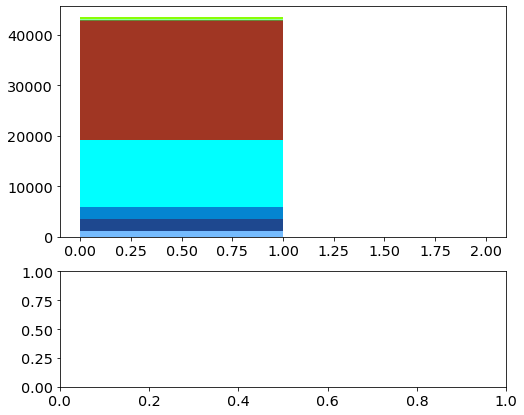

In [32]:
#bnbdata

import matplotlib.pyplot as plt
import matplotlib

print(SEL_QUERY)
VARIABLE, BINS, RANGE, XTIT = 'bnbdata',2,(0.0,2.0),"bnb data"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = False,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, NuMu - bnbdata',loc='left')
ax1.set_yscale("log")
fig.tight_layout()

nslice == 1
nslice == 1& extdata <= 2 & extdata >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  1184.6528973373554  c  31
order w sum  2347.1468964318847  c  3
order w sum  2417.7970251854567  c  21
order w sum  13215.808157724492  c  2
order w sum  23576.997310890878  c  5
order w sum  243.94473084531342  c  1
order w sum  0  c  12
order w sum  120.5903182191437  c  10
order w sum  390.0633804915802  c  11
[1184.653    0.   ]
sum:  1184.6528973373538


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


IndexError: index 2 is out of bounds for axis 0 with size 2

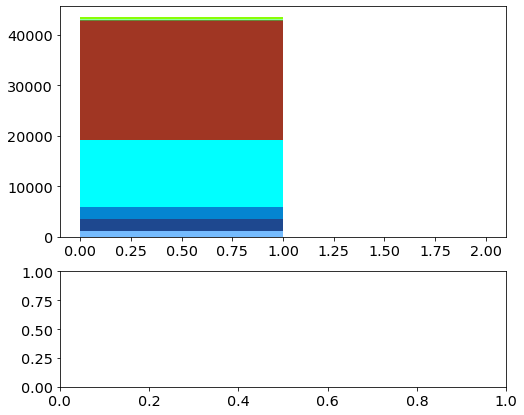

In [33]:
#ext data

import matplotlib.pyplot as plt
import matplotlib

print(SEL_QUERY)
VARIABLE, BINS, RANGE, XTIT = 'extdata',2,(0.0,2.0),"ext data"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = False,           #False as plotting MC
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, NuMu - ext data',loc='left')
ax1.set_yscale("log")
fig.tight_layout()

efficiency =  0.7733102346858675
purity =  0.31952785765532976
In bin 0 , eff =  0.706890450432233  with error =  0.0022885052974893605
In bin 1 , eff =  0.7769974930899274  with error =  0.0016686750018628151
In bin 2 , eff =  0.7955394443093654  with error =  0.0018961361983953987
In bin 3 , eff =  0.809971098265896  with error =  0.003044289307736707
In bin 4 , eff =  0.8069436539556062  with error =  0.0042110729350420565
In bin 5 , eff =  0.8040143912137853  with error =  0.00546243042721001
In bin 6 , eff =  0.8168414154652687  with error =  0.007001486395407316


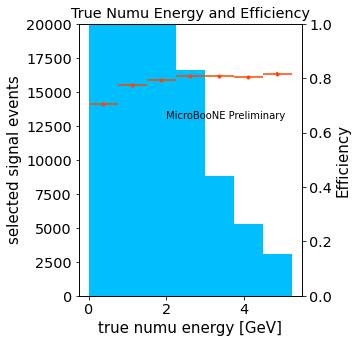

In [34]:
#SEL_QUERY_B = SEL_QUERY
SEL_QUERY += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
selected = mc.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

selCC = len(selected.query(fiduc_q))
totCC = len(mc.query(fiduc_q))
eff = selCC/totCC
print("efficiency = ",eff)
effs.append(eff)

lnue = len(mc.query(SEL_QUERY)) * 0.08559738414394057
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057    #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.08442202570650682   #check this one!!
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)

print("purity = ", pur)
purs.append(pur)

bins = np.arange(0, 6.0, 0.75)
plot_signal_and_eff(selected_fid, mc, fiduc_q, bins, mc.query(fiduc_q))

nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  1158.9407829307493  c  31
order w sum  2282.585270359426  c  3
order w sum  2369.6220300715327  c  21
order w sum  12937.53621575342  c  2
order w sum  22752.256528479313  c  5
order w sum  237.74894024145428  c  1
order w sum  0  c  12
order w sum  119.40726977830536  c  10
order w sum  381.07607475966927  c  11
[16.225 81.553 92.111 88.022 87.993 93.854 90.605 89.404 90.158 84.924
 82.313 88.858 85.866 78.144  6.799]
sum:  1156.8303578609712
[ 56.507 228.767 258.29  262.145 250.121 268.492 273.071 261.119 261.49
 263.587 264.406 261.645 259.758 225.199  38.78 ]
sum:  3433.377774146523
[ 91.935 409.066 445.683 450.189 436.074 456.003 454.422 446.98  442.363
 441.416 431.832 438.592 428.614 379.342  48.855]
sum:  5801.36485

/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:459: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )


nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  1158.9407829307493  c  31
order w sum  2282.585270359426  c  3
order w sum  2369.6220300715327  c  21
order w sum  12937.53621575342  c  2
order w sum  22752.256528479313  c  5
order w sum  237.74894024145428  c  1
order w sum  0  c  12
order w sum  119.40726977830536  c  10
order w sum  381.07607475966927  c  11
[ 6.027 31.766 41.203 44.248 43.125 43.852 43.212 43.499 43.006 41.797
 39.02  39.615 40.629 42.28  46.219 36.807 38.59  40.93  39.084 40.637
 40.773 40.482 39.312 37.316 40.91  40.698 38.63  34.051 28.42  20.948]
sum:  1147.0881613891418
[ 32.935  90.308 115.492 118.841 125.107 126.334 123.117 124.069 123.175
 121.917 112.931 118.8   117.474 115.18  122.382 113.705 117.221 119.437
 113.06  118.523 116.939 124.744 119.074 117.171 117.327 120.737 112.69
 104.59   94.88   94.606]
sum:  3392.7629008159747
[ 42.482 149

/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:459: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )


nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  1158.9407829307493  c  31
order w sum  2282.585270359426  c  3
order w sum  2369.6220300715327  c  21
order w sum  12937.53621575342  c  2
order w sum  22752.256528479313  c  5
order w sum  237.74894024145428  c  1
order w sum  0  c  12
order w sum  119.40726977830536  c  10
order w sum  381.07607475966927  c  11
[14.928 34.18  31.67  37.253 36.946 41.671 38.797 38.615 39.748 44.167
 46.386 39.805 44.507 42.902 47.52  45.686 48.152 48.488 47.951 43.414
 23.623 44.582 49.008 44.855 44.684 46.074 41.7   38.804 11.937  0.887]
sum:  1158.9407829307472
[ 54.199  85.853  95.264 103.118 112.462 124.194 119.417 121.98  125.876
 130.902 140.261 126.189 127.54  132.809 137.123 139.801 139.099 140.094
 142.495 138.459  70.347 136.31  142.384 128.96  130.527 125.359 123.126
 105.834  36.576   4.965]
sum:  3441.5260532901793
[ 75.643 16

/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:459: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )


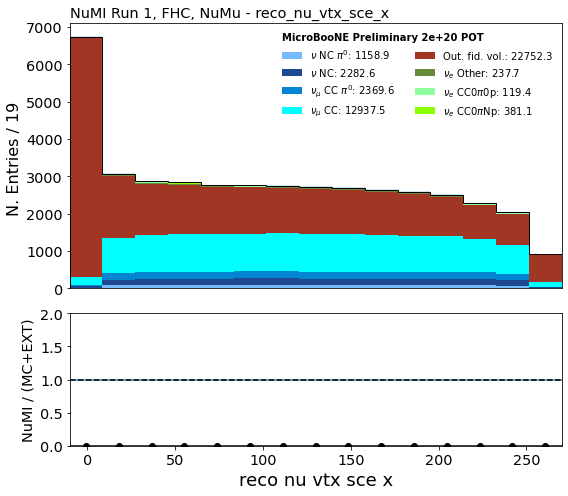

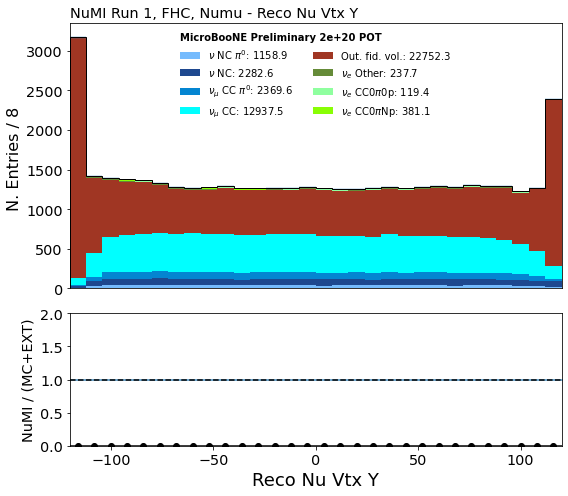

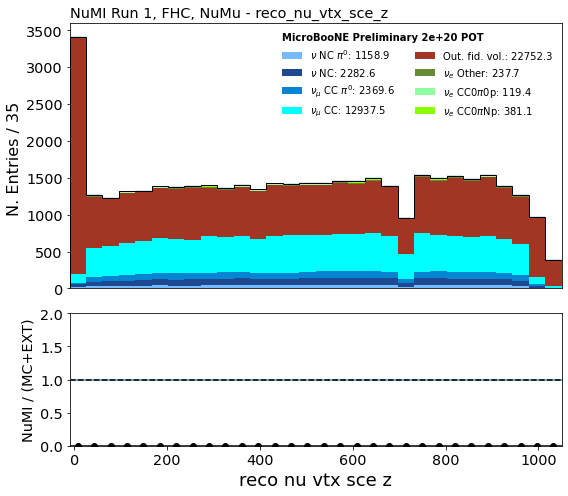

In [35]:
#reco_nu_vtx_sce_x

import matplotlib.pyplot as plt
import matplotlib

print(SEL_QUERY)
VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',15,(-10.0,270.0),"reco nu vtx sce x"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = False,           #False as plotting MC
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, NuMu - reco_nu_vtx_sce_x',loc='left')
#ax1.set_yscale("log")
fig.tight_layout()

################################################################

#reco_nu_vtx_sce_y

VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',30,(-120.0,120.0),"Reco Nu Vtx Y"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = False,           #False as plotting MC
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, Numu - Reco Nu Vtx Y',loc='left')
#ax1.set_yscale("log")
fig.tight_layout()

################################################################

#reco_nu_vtx_sce_z

VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',30,(-10.0,1050.0),"reco nu vtx sce z"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = False,           #False as plotting MC
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, NuMu - reco_nu_vtx_sce_z',loc='left')
#ax1.set_yscale("log")
fig.tight_layout()

efficiency =  0.7536583385215061
purity =  0.35122389137114673
In bin 0 , eff =  0.637104405425297  with error =  0.003486326551203475
In bin 1 , eff =  0.7350273574210086  with error =  0.0021909292723962166
In bin 2 , eff =  0.761980376356828  with error =  0.0020732559777876013
In bin 3 , eff =  0.7770594430142757  with error =  0.0022511800025912625
In bin 4 , eff =  0.7857690622261174  with error =  0.003036587106468576
In bin 5 , eff =  0.7939207142097991  with error =  0.004169980294069531
In bin 6 , eff =  0.7902307935504268  with error =  0.0051189778275151235
In bin 7 , eff =  0.7908396946564885  with error =  0.006006399204965042
In bin 8 , eff =  0.7882725832012678  with error =  0.007273225932103263
In bin 9 , eff =  0.7979204339963833  with error =  0.008537848269762671


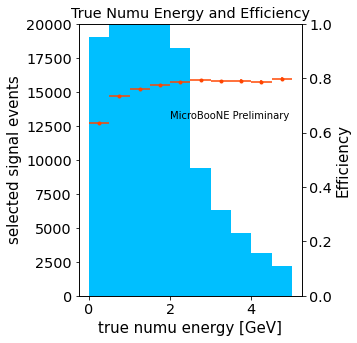

In [36]:
#SEL_QUERY += ' and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251 '
SEL_QUERY += ' and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 '
#SEL_QUERY += ' and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 '
SEL_QUERY += ' and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 '
#SEL_QUERY += ' and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986 '
SEL_QUERY += ' and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 '
selected = mc.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

selCC = len(selected.query(fiduc_q))
totCC = len(mc.query(fiduc_q))
eff = selCC/totCC
print("efficiency = ",eff)
effs.append(eff)

lnue = len(mc.query(SEL_QUERY)) * 0.08559738414394057
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057    #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.08442202570650682   #check this one!!
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)


print("purity = ", pur)
purs.append(pur)

bins = np.arange(0, 5.5, 0.5)
plot_signal_and_eff(selected_fid, mc, fiduc_q, bins, mc.query(fiduc_q))

nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 & n_muons_tot <= 5 & n_muons_tot >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  1125.9087160488093  c  31
order w sum  2169.132649711824  c  3
order w sum  2331.7226869670844  c  21
order w sum  12629.350015575179  c  2
order w sum  19767.21964622172  c  5
order w sum  232.8478953660204  c  1
order w sum  0  c  12
order w sum  114.1516599801091  c  10
order w sum  373.59179002497785  c  11
[1.016e+03 1.036e+02 5.545e+00 2.655e-01 0.000e+00]
sum:  1125.9087160488064


IndexError: index 5 is out of bounds for axis 0 with size 5

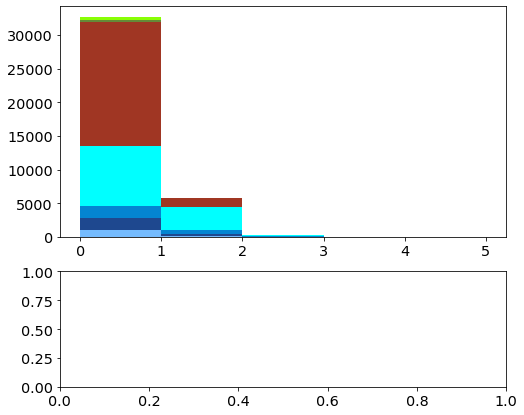

In [37]:
#n_muons_tot

import matplotlib.pyplot as plt
import matplotlib

#print(SEL_QUERY)
VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',5,(0.0,5.0),"n muons tot"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = False,           #False as plotting MC
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, NuMu - n muons tot',loc='left')
ax1.set_yscale("log")
fig.tight_layout()

efficiency =  0.1977478818720732
purity =  0.5034134665664991
In bin 0 , eff =  0.27226369466933026  with error =  0.0032274074632076266
In bin 1 , eff =  0.27606348893379995  with error =  0.002219375635278363
In bin 2 , eff =  0.192562923638432  with error =  0.0019196202831620183
In bin 3 , eff =  0.1552480692721741  with error =  0.0019586925006987096
In bin 4 , eff =  0.14039219982471515  with error =  0.0025710992984290517
In bin 5 , eff =  0.13954724200233817  with error =  0.003572336903254481
In bin 6 , eff =  0.12978185267151437  with error =  0.004225289387254871
In bin 7 , eff =  0.12933478735005452  with error =  0.00495579807880186
In bin 8 , eff =  0.1410459587955626  with error =  0.00619677325938348
In bin 9 , eff =  0.13652802893309224  with error =  0.007300329646769971


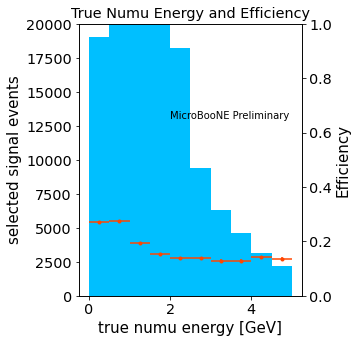

In [38]:
SEL_QUERY += ' and n_muons_tot > 0'
#see what happens i tn_muons_tot == 1

selected = mc.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

selCC = len(selected.query(fiduc_q))
totCC = len(mc.query(fiduc_q))
eff = selCC/totCC
print("efficiency = ",eff)
effs.append(eff)

lnue = len(mc.query(SEL_QUERY)) * 0.08559738414394057
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057    #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.08442202570650682   #check this one!!
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)

print("purity = ", pur)
purs.append(pur)

bins = np.arange(0, 5.5, 0.5)
plot_signal_and_eff(selected_fid, mc, fiduc_q, bins, mc.query(fiduc_q))

nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0& n_protons_tot <= 8 & n_protons_tot >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  109.41496775562655  c  31
order w sum  360.63953132963456  c  3
order w sum  600.9304958913716  c  21
order w sum  1315.1153610388258  c  5
order w sum  3675.939223341625  c  2
order w sum  39.52428904533051  c  1
order w sum  0  c  12
order w sum  5.287420718734101  c  10
order w sum  25.311145060953702  c  11
[67.519 28.416 10.491  1.897  0.73   0.362  0.     0.   ]
sum:  109.4149677556266


IndexError: index 8 is out of bounds for axis 0 with size 8

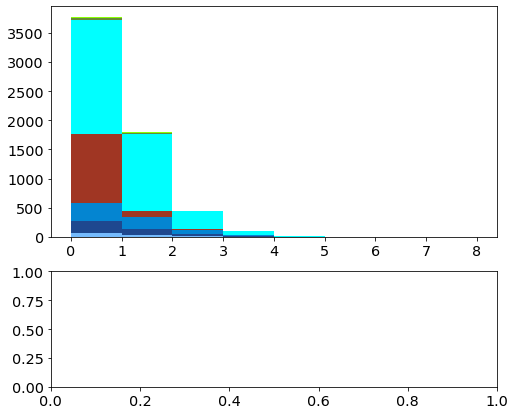

In [39]:
#n_protons_tot

import matplotlib.pyplot as plt
import matplotlib

#print(SEL_QUERY)
VARIABLE, BINS, RANGE, XTIT = 'n_protons_tot',8,(0.0,8.0),"n protons tot"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = False,           #False as plotting MC
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, NuMu - n protons tot',loc='left')
ax1.set_yscale("log")
fig.tight_layout()

efficiency =  0.1187938175026392
purity =  0.8608806721757585
In bin 0 , eff =  0.14167805698664704  with error =  0.0025284147495586422
In bin 1 , eff =  0.17624587174052347  with error =  0.0018916220430199426
In bin 2 , eff =  0.11736265819784804  with error =  0.0015668620722747992
In bin 3 , eff =  0.09419611514158671  with error =  0.001579872885248235
In bin 4 , eff =  0.08424627519719544  with error =  0.0020557101848720748
In bin 5 , eff =  0.08204910192369008  with error =  0.002829273339316834
In bin 6 , eff =  0.0725576983876067  with error =  0.0032615242017991954
In bin 7 , eff =  0.07219193020719739  with error =  0.0038221148210899883
In bin 8 , eff =  0.08367670364500793  with error =  0.004929773476860574
In bin 9 , eff =  0.07368896925858952  with error =  0.005555038809865525


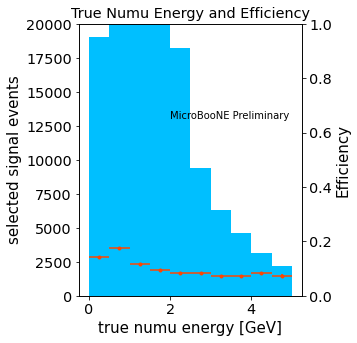

In [40]:
SEL_QUERY += ' and n_protons_tot > 0 '

selected = mc.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

selCC = len(selected.query(fiduc_q))
totCC = len(mc.query(fiduc_q))
eff = selCC/totCC
print("efficiency = ",eff)
effs.append(eff)

lnue = len(mc.query(SEL_QUERY)) * 0.08559738414394057
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057    #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.08442202570650682   #check this one!!
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)

print("purity = ", pur)
purs.append(pur)

bins = np.arange(0, 5.5, 0.5)
plot_signal_and_eff(selected_fid, mc, fiduc_q, bins, mc.query(fiduc_q))

In [41]:
#Save the DataFrame to a csv file to check for any crossover in datapoints
selected = mc.query(SEL_QUERY)
fiduc_q = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and (abs(nu_pdg) == 12 and ccnc == 0) and nproton > 0"
selected_fid = selected.query(fiduc_q)
selected_fid.to_csv('numu_full_mc_nu_e.csv')

## Purity and Efficiency

Selection Efficiency = no. reconstructed neutrinos classified as numu CC that pass selection / total number of these simulated in the fiducial volume.

Selection Purity = no. reconstructed neutrinos classified as numu CC that pass selection / total number of selected neutrinos in any classification.

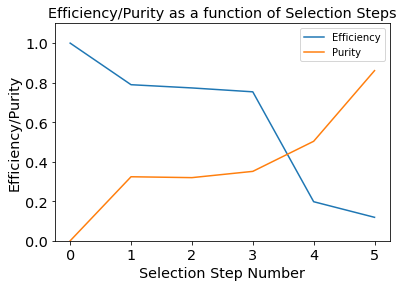

In [42]:
#make an efficiency/purity plot for each of the selection steps

plt.plot(effs)
plt.plot(purs)
plt.title("Efficiency/Purity as a function of Selection Steps")
plt.xlabel("Selection Step Number")
plt.ylabel("Efficiency/Purity")
plt.ylim([0,1.1])
plt.legend(["Efficiency", "Purity"])
plt.show()

nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 & muon_Angle_Numi_Theta <= 1 & muon_Angle_Numi_Theta >= -0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  34.791473185426526  c  31
order w sum  100.97177162148871  c  5
order w sum  119.5150375521311  c  3
order w sum  233.709428469091  c  21
order w sum  1332.026894304401  c  2
order w sum  13.451973009202971  c  1
order w sum  0  c  12
order w sum  0.356587345429631  c  10
order w sum  8.07584492650366  c  11
[0.232 0.25  0.74  0.909 1.445 1.502 1.784 2.834 3.166 4.632 3.125 2.283
 1.863 2.121 1.748 1.485 1.188 1.737 0.665 1.084]
sum:  34.79147318542651
[ 0.765  1.553  2.394  2.836  4.07   4.621  7.363  9.618 12.583 17.639
 13.472  9.843  9.548  8.

/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:459: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )


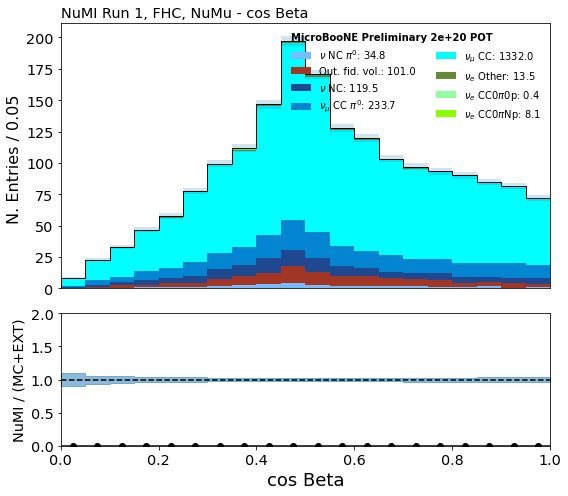

In [43]:
#Now check on a variable

import matplotlib.pyplot as plt
import matplotlib

VARIABLE, BINS, RANGE, XTIT = 'muon_Angle_Numi_Theta',20,(-0.0,1),"cos Beta"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    #kind="interaction",
    kind="event_category",
    draw_sys  = systematicsBool, 
    draw_geoSys = False, 
    draw_data = False,           #False as plotting MC
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, NuMu - cos Beta',loc='left')
#ax1.set_yscale("log")
fig.tight_layout()

nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0  and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < 254.8 and true_nu_vtx_x > -1.55 and (abs(nu_pdg) == 14 and ccnc == 0) & nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  0.6537326276552337  c  31
order w sum  2.9239782596155677  c  3
order w sum  18.20475314635319  c  5
order w sum  290.42601583943514  c  21
order w sum  1700.335611717287  c  2
[0.    0.    0.061 0.286 0.233 0.074 0.    0.    0.    0.   ]
sum:  0.6537326276552337
[0.868 0.924 0.59  0.782 0.339 0.074 0.    0.    0.    0.   ]
sum:  3.5777108872708014
[2.189 5.78  4.347 4.297 2.22  0.63  0.82  0

/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:459: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )


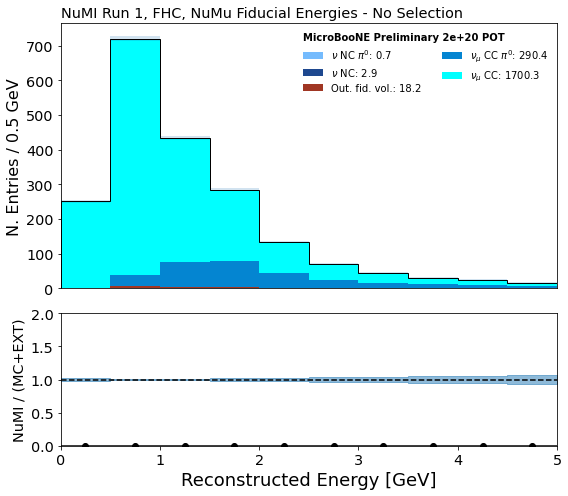

In [45]:
import matplotlib.pyplot as plt
import matplotlib

systematicsBool = False

SEL_QUERYB =SEL_QUERY + ' and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < 254.8 and true_nu_vtx_x > -1.55 and (abs(nu_pdg) == 14 and ccnc == 0) '

#why is this not just nu_e?
VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

#in the fiducial volume
#fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and (abs(nu_pdg) == 14 and ccnc == 0)"
#FID_QUERY = fiduc

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERYB,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = False,           #False as plotting MC
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]


ax1.set_title('NuMI Run 1, FHC, NuMu Fiducial Energies - No Selection',loc='left')
#ax2.set_ylim(0.95,1.05)

fig.tight_layout()

nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 & nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  35.61019607029494  c  31
order w sum  108.92072755199841  c  5
order w sum  140.06638015874495  c  3
order w sum  290.42601583943514  c  21
order w sum  1700.335611717287  c  2
order w sum  17.031231254500955  c  1
order w sum  0  c  12
order w sum  0.356587345429631  c  10
order w sum  10.20955674493298  c  11
[0.123 0.944 3.631 7.232 6.579 6.18  2.402 3.168 3.121 2.231]
sum:  35.610196070294926
[10.678 22.848 24.648 27.329 19.121 12.529  8.953  7.756  6.027  4.642]
sum:  144.53092362229333
[14.17  34.907 53.421 59.95  41.864 28.154 17.997 14.435 10.423  9.276]
sum:  284.597303781

/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:459: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )


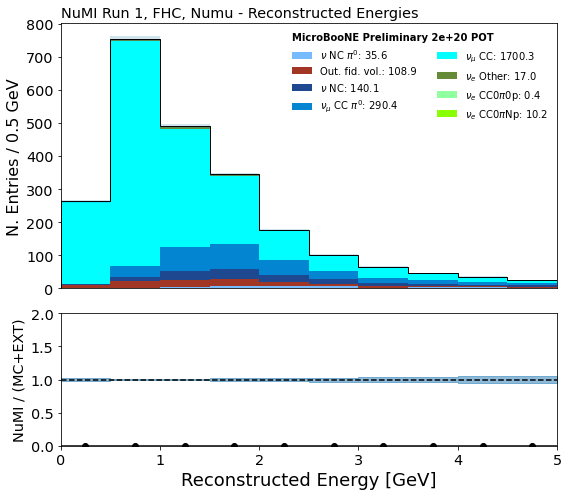

In [46]:
#Now check on a variable


import matplotlib.pyplot as plt
import matplotlib

VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    #kind="interaction",
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = False,           #False as plotting MC
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, Numu - Reconstructed Energies',loc='left')
#ax1.set_yscale("log")
fig.tight_layout()

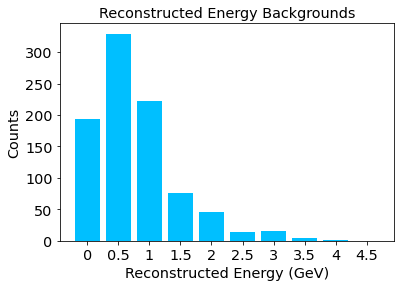

In [36]:
#Background numbers plot

bkg_nums = [194.2, 329.3, 221.9, 75.7, 45.3, 14.4, 16.2, 4.8, 1.2, 0.2]

import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 5, 0.5)
names = ['0', '0.5', '1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5']
#gen = plt.hist(bkg_nums, bins, color='orange')
plt.bar(names, bkg_nums, color='deepskyblue')
plt.xlabel("Reconstructed Energy (GeV)")
plt.ylabel("Counts")
plt.title("Reconstructed Energy Backgrounds")
plt.show()

In [54]:
##################################################################

In [47]:
def plot_signal_and_eff_and_B(selected, df, signal, bins, truth): 
    
    # generated true signal events per bin 
    gen = plt.hist(df.query(signal)['nu_e'], bins, color='deepskyblue')
    plt.close()
    print("Full numbers = ", gen[0])
    
    #This should give selected numbers in bin
    #print(selected['neutrino_energy'])
    #This should be the total numbers in bin
    #print(df.query(signal)['neutrino_energy'])
    
    # plot selected signal events 
    fig, ax1 = plt.subplots(figsize=(4, 5))
    
    sel = ax1.hist(truth['nu_e'], bins, color='deepskyblue')
    ax1.set_ylabel('Selected Signal Events', fontsize=15)
    ax1.set_xlabel('True Numu Energy [GeV]', fontsize=15)

    # compute efficiency
    sel = ax1.hist(selected['nu_e'], bins, color='white')
    print("Selected numbers = ", sel[0])
    eff = [ a/b for a, b in zip(sel[0], gen[0]) ]
    eff_err = []
    for i in range(len(eff)):
        eff_err.append(math.sqrt( (eff[i]*(1-eff[i]))/gen[0][i] ) )
        print("In bin", i, ", eff = ", eff[i], " with error = ", eff_err[i])
        
    # compute bin centers 
    bc = 0.5*(sel[1][1:]+sel[1][:-1])
    x_err = []
    for i in range(len(sel[1])-1): 
        x_err.append((sel[1][i+1]-sel[1][i])/2)

    # plot efficiency
    sel = ax1.hist(truth['nu_e'], bins, color='deepskyblue')
    ax1.set_ylim(0, 20000)
    ax2 = ax1.twinx()
    ax2.errorbar(bc, eff, xerr=x_err, yerr=eff_err, fmt='o', color='orangered', ecolor='orangered', markersize=3) 
    ax2.set_ylim(0, 1.00)
    ax2.set_ylabel('Efficiency', fontsize=15)
    ax2.set_title("True Numu Energy and Efficiency") 
    plt.text(0, 0.95, r'MicroBooNE Preliminary', fontweight='bold')

    plt.show()

Full numbers =  [ 536. 2893. 2706. 1335.  740.  395.  254.  130.   82.   50.]
Selected numbers =  [ 6. 73. 99. 61. 26. 26. 13.  7.  5.  3.]
In bin 0 , eff =  0.011194029850746268  with error =  0.0045442935239078395
In bin 1 , eff =  0.02523332181126858  with error =  0.002915837612224539
In bin 2 , eff =  0.036585365853658534  with error =  0.0036090792987554707
In bin 3 , eff =  0.045692883895131084  with error =  0.0057151513102658815
In bin 4 , eff =  0.03513513513513514  with error =  0.006768434029252194
In bin 5 , eff =  0.06582278481012659  with error =  0.012476828732298311
In bin 6 , eff =  0.051181102362204724  with error =  0.013827052840312583
In bin 7 , eff =  0.05384615384615385  with error =  0.019796414897289276
In bin 8 , eff =  0.06097560975609756  with error =  0.026424670838333334
In bin 9 , eff =  0.06  with error =  0.03358571124749333


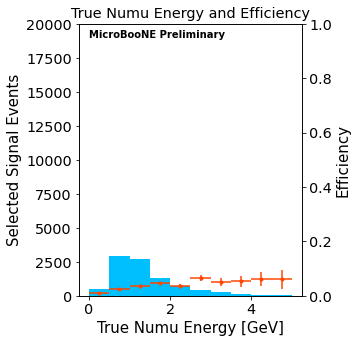

In [55]:
selected = mc.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

bins = np.arange(0, 5.5, 0.5)
plot_signal_and_eff_and_B(selected_fid, mc, fiduc_q, bins, mc.query(fiduc_q))

### Smearing Matrix Work

In [49]:
# plot the smearing matrix 
def plot_smearing(selected, signal, true, reco, bins, norm=False): 
    fig = plt.figure(figsize=(10, 6))
    
    smear = plt.hist2d(selected.query(signal)[true],selected.query(signal)[reco],
                   bins, cmin=0.000000001, cmap='OrRd')

    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if smear[0].T[i,j] > 0: 
                if smear[0].T[i,j]>80: 
                    col='white'
                else: 
                    col='black'
                    
                binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                        
                plt.text(binx_centers, biny_centers, round(smear[0].T[i,j], 1), 
                    color=col, ha="center", va="center", fontsize=12)

    cbar = plt.colorbar()
    cbar.set_label('Selected Signal Events', fontsize=15)

    if norm: 
        plt.close()
        
        norm_array = smear[0].T
    
        # for each truth bin (column): 
        for j in range(len(bins)-1): 
        
            reco_events_in_column = [ norm_array[i][j] for i in range(len(bins)-1) ]
            tot_reco_events = np.nansum(reco_events_in_column)
        
            # replace with normalized value 
            for i in range(len(bins)-1): 
                norm_array[i][j] =  norm_array[i][j] / tot_reco_events
    
        # now plot
        fig = plt.figure(figsize=(10, 6))
        plt.pcolor(bins, bins, norm_array, cmap='OrRd', vmax=1)
    
        # Loop over data dimensions and create text annotations.
        for i in range(len(bins)-1): # reco bins (rows)
            for j in range(len(bins)-1): # truth bins (cols)
                if norm_array[i][j]>0: 
                
                    if norm_array[i][j]>0.7: 
                        col = 'white'
                    else: 
                        col = 'black'
                    
                    binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                    biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                
                    plt.text(binx_centers, biny_centers, round(norm_array[i][j], 2), 
                         ha="center", va="center", color=col, fontsize=12)
      
        cbar = plt.colorbar()
        cbar.set_label('Fraction of Reco Events in True Bin', fontsize=15)

    plt.xlabel('True Nu Energy [GeV]', fontsize=15)
    plt.ylabel('Reco Nu Energy [GeV]', fontsize=15)
    plt.text(0.1, 4.2, r'MicroBooNE Preliminary', fontweight='bold')
    
    plt.show()

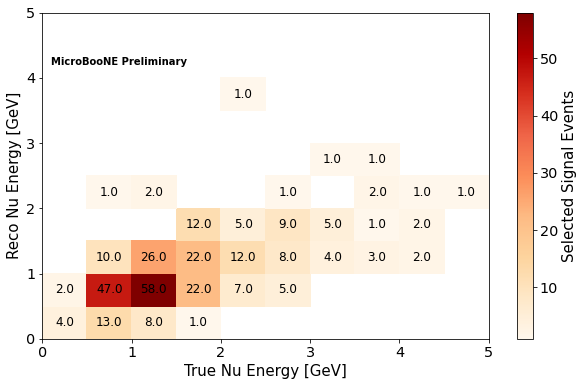

In [50]:
# true nu energy 
true_var = 'nu_e'

# reconstructed nu energy 
reco_var = 'neutrino_energy'

bins = np.arange(0, 5.5, 0.5)

# relationship between true & reco values
plot_smearing(selected_fid, fiduc_q, true_var, reco_var, bins)

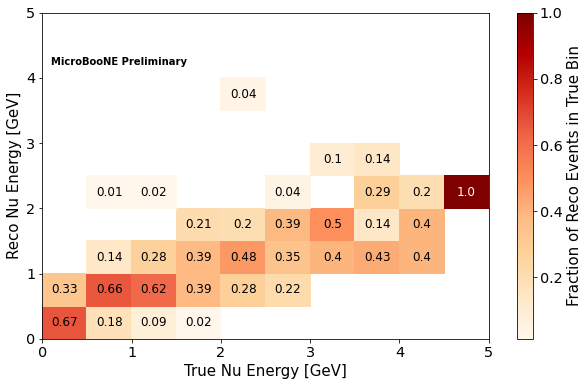

In [51]:
# relationship between true & reco values
plot_smearing(selected_fid, fiduc_q, true_var, reco_var, bins, norm=True)

In [57]:
# Calculate true numbers
#bkg_nums = [194.2, 329.3, 221.9, 75.7, 45.3, 14.4, 16.2, 4.8, 1.2, 0.2]
#n_data = [570, 1094, 541, 205, 88, 28, 22, 6, 2, 1]
#n_selected = [375.776, 764.668, 319.06, 129.321, 42.668, 13.563, 5.8, 1.249, 0.787, 0.808]
n_selected = [ 6, 73, 99, 61, 26, 26, 13,  7,  5, 3]

true0 = (n_selected[0]*0.67) + (n_selected[1]*0.33)
true05 = (n_selected[0]*0.18) + (n_selected[1]*0.66) + (n_selected[2]*0.14) + (n_selected[4]*0.01)
true1 = (n_selected[0]*0.09) + (n_selected[1]*0.62) + (n_selected[2]*0.28) + (n_selected[4]*0.02)
true15 = (n_selected[0]*0.02) + (n_selected[1]*0.39) + (n_selected[2]*0.39) + (n_selected[3]*0.21)
true2 = (n_selected[1]*0.28) + (n_selected[2]*0.48) + (n_selected[3]*0.2) + (n_selected[7]*0.04)
true25 = (n_selected[1]*0.22) + (n_selected[2]*0.35) + (n_selected[3]*0.39) + (n_selected[4]*0.04)
true3 = (n_selected[2]*0.4) + (n_selected[3]*0.5) + (n_selected[5]*0.1)
true35 = (n_selected[2]*0.43) + (n_selected[3]*0.14) + (n_selected[4]*0.29) + (n_selected[5]*0.14)
true4 = (n_selected[2]*0.4) + (n_selected[3]*0.4) + (n_selected[4]*0.2)
true45 = (n_selected[4]*1.0)

In [56]:
#multiply by efficiency and sum

eff = [0.011194029850746268, 0.02523332181126858, 0.036585365853658534, 0.036585365853658534, 0.03513513513513514, 0.06582278481012659, 0.051181102362204724, 0.05384615384615385, 0.06097560975609756, 0.06]
truths = [true0, true05, true1, true15, true2, true25, true3, true35, true4, true45]
ratio_nums = []

for i in range(len(truths)):
    num = truths[i]*(1/eff[i])
    ratio_nums.append(num)
    
print("Numbers of Ratio, numu: ", ratio_nums)
print("Ratio number, numu: ", sum(ratio_nums))


Numbers of Ratio, numu:  [2511.1600000000003, 2511.7580821917804, 2023.76, 2186.9400000000005, 2289.4461538461537, 1147.626923076923, 1420.4461538461537, 1156.8142857142855, 1134.88, 433.33333333333337]
Ratio number, numu:  16816.16493200863


In [55]:
numu_ratio_nums = [1725.6085400000002, 1304.3992394366198, 994.6001761797753, 928.1044897058824, 961.0822222222222, 664.07974, 193.6408, 169.57327999999998]
nue_ratio_nums = [169.65557084690553, 236.25330795610427, 219.64615869792848, 154.48206614192907, 112.50032740259738, 87.20084442516269, 59.47250931034483, 94.09295064390247, 93.96329558309857, 50.10685366666666]
bin_ratios = []

for i in range(len(numu_ratio_nums)):
    ratio = nue_ratio_nums[i]/numu_ratio_nums[i]
    bin_ratios.append(ratio)
    
print(bin_ratios)

[0.18943664367064422, 0.22275933487506627, 0.25931459659901207, 0.27145557801670567, 0.24747569402925496, 0.2444173751971049, 0.21925017560821927, 0.3473526083186562, 0.41063759221785096, 0.23375382515513637]


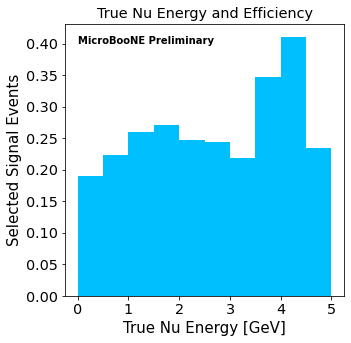

In [62]:
    count = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6]
    
    weights = [0.1*0.18943664367064422, 0.6*0.22275933487506627, 1.1*0.25931459659901207, 1.6*0.27145557801670567, 2.1*0.24747569402925496, 2.6*0.2444173751971049, 3.1*0.21925017560821927, 3.6*0.3473526083186562, 4.1*0.41063759221785096, 4.6*0.23375382515513637]
    
    
    # plot selected signal events 
    fig, ax1 = plt.subplots(figsize=(5, 5))
    
    sel = ax1.hist(count, bins, color='deepskyblue', weights=bin_ratios)
    ax1.set_ylabel('Selected Signal Events', fontsize=15)
    ax1.set_xlabel('True Nu Energy [GeV]', fontsize=15)
    #ax1.set_ylim(0, 3500)
    ax1.set_title("True Nu Energy and Efficiency")
    
    plt.text(0, 0.40, r'MicroBooNE Preliminary', fontweight='bold')
    plt.show()

In [64]:
pandas.set_option('display.max_rows', 20)
pandas.set_option('display.max_columns', None)
print(mc)

         backtracked_pdg  npion  CosmicIPAll3D  reco_nu_vtx_y  reco_nu_vtx_z  \
entry                                                                          
0                   [13]      0    9999.000000  -9.079936e+01   6.548632e+01   
1       [2212, 13, 2212]      0    9999.000000  -2.437185e+01   5.593128e+02   
2                     []      1    9999.000000  -3.402823e+38  -3.402823e+38   
3                    [0]      1    9999.000000   2.158122e+01   1.164420e+02   
4                     []      0    9999.000000  -3.402823e+38  -3.402823e+38   
...                  ...    ...            ...            ...            ...   
914724                []      0    9999.000000  -3.402823e+38  -3.402823e+38   
914725            [0, 0]      0    9999.000000   8.783094e+01   1.235672e+02   
914726                []      1    9999.000000  -3.402823e+38  -3.402823e+38   
914727                []      0    9999.000000  -3.402823e+38  -3.402823e+38   
914728       [13, 13, 0]      0     118.